In [1]:
from optimizer import Optimizer
from heuristics import * 
import random 

In [2]:
num_parts = 20
group_length = 2
max_time_machine_A = 24000 + ((num_parts - 10) * 4000)
max_time_machine_B = 22000
demand = {p: 50 for p in range(1, num_parts + 1)}
demand[num_parts + 1] = 0
demand[num_parts + 2] = 0

color_cost = {
    'Red': 10, 'Blue': 10, 'Green': 10, 'Yellow': 10,
    'Black': 10, 'Pink': 10, 'Purple': 10,
}

parts_colors = {i: random.choice(list(color_cost.keys())) for i in range(1, num_parts + 1)}

alpha = [[abs(1 - (parts_colors[p] == parts_colors[q])) for q in range(1, num_parts + 1)] for p in range(1, num_parts + 1)]
unit_production_time = 80
cleaning_time = 80

machines = [1,2]

In [3]:
tabu = TabuSearchScheduler(10,100,num_parts, group_length, max_time_machine_A, max_time_machine_B,
                 demand, color_cost, parts_colors, alpha, unit_production_time, 
                 cleaning_time, machines)

best_solution, best_value, elapsed_time = tabu()
best_value, elapsed_time
best_solution
print(round(elapsed_time, 4))

0.0192


In [4]:
best_solution

{1: [(1, 0, 4000),
  (9, 4000, 8000),
  (2, 8080, 12080),
  (12, 12080, 16080),
  (13, 16160, 20160),
  (20, 20160, 24160),
  (6, 24240, 28240),
  (8, 28240, 32240),
  (17, 32240, 36240),
  (7, 36320, 40320),
  (15, 40320, 44320),
  (16, 44320, 48320),
  (18, 48320, 52320),
  (19, 52320, 56320),
  (11, 56400, 60400)],
 2: [(5, 0, 4000),
  (10, 4000, 8000),
  (4, 8080, 12080),
  (3, 12160, 16160),
  (14, 16160, 20160)]}

In [5]:
benchmark_optimizer = Optimizer(num_parts, group_length, max_time_machine_A, max_time_machine_B, demand, parts_colors, alpha, unit_production_time, cleaning_time)
benchmark_model, optimization_time = benchmark_optimizer()
print(optimization_time)

Set parameter Username
Set parameter LicenseID to value 2581974
Academic license - for non-commercial use only - expires 2025-11-11
Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2372 rows, 1012 columns and 24624 nonzeros
Model fingerprint: 0x6d8826fd
Variable types: 44 continuous, 968 integer (968 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 810 rows and 172 columns
Presolve time: 0.03s
Presolved: 1562 rows, 840 columns, 19800 nonzeros
Variable types: 40 continuous, 800 integer (800 binary)
Found heuristic solution: objective 17.0000000

Root relaxation: objective 1.000000e+00, 125 iterations, 0.00 seconds (0.00 work uni

## Visualization

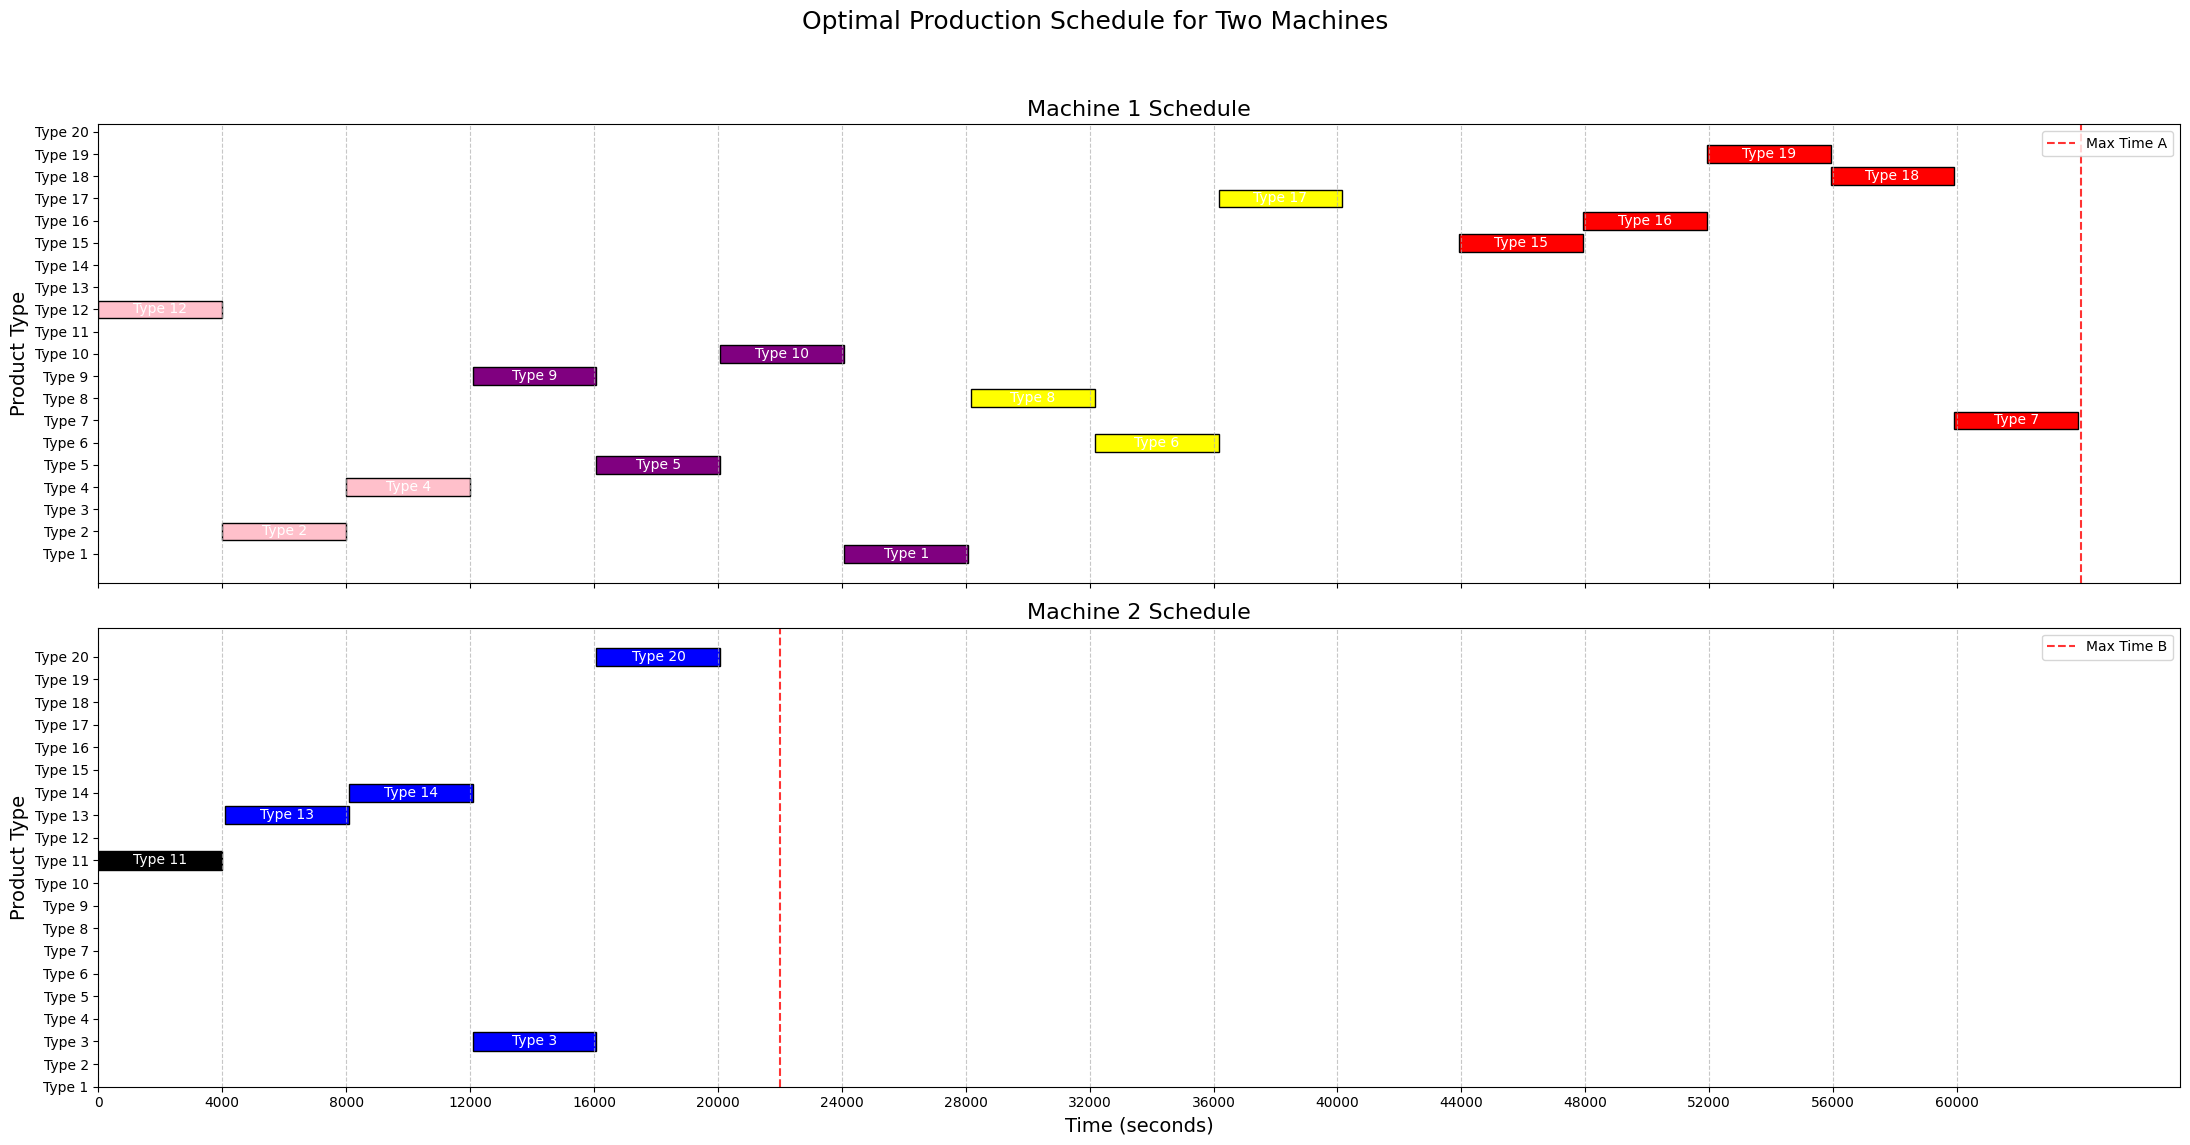

In [6]:
benchmark_optimizer.visualize()

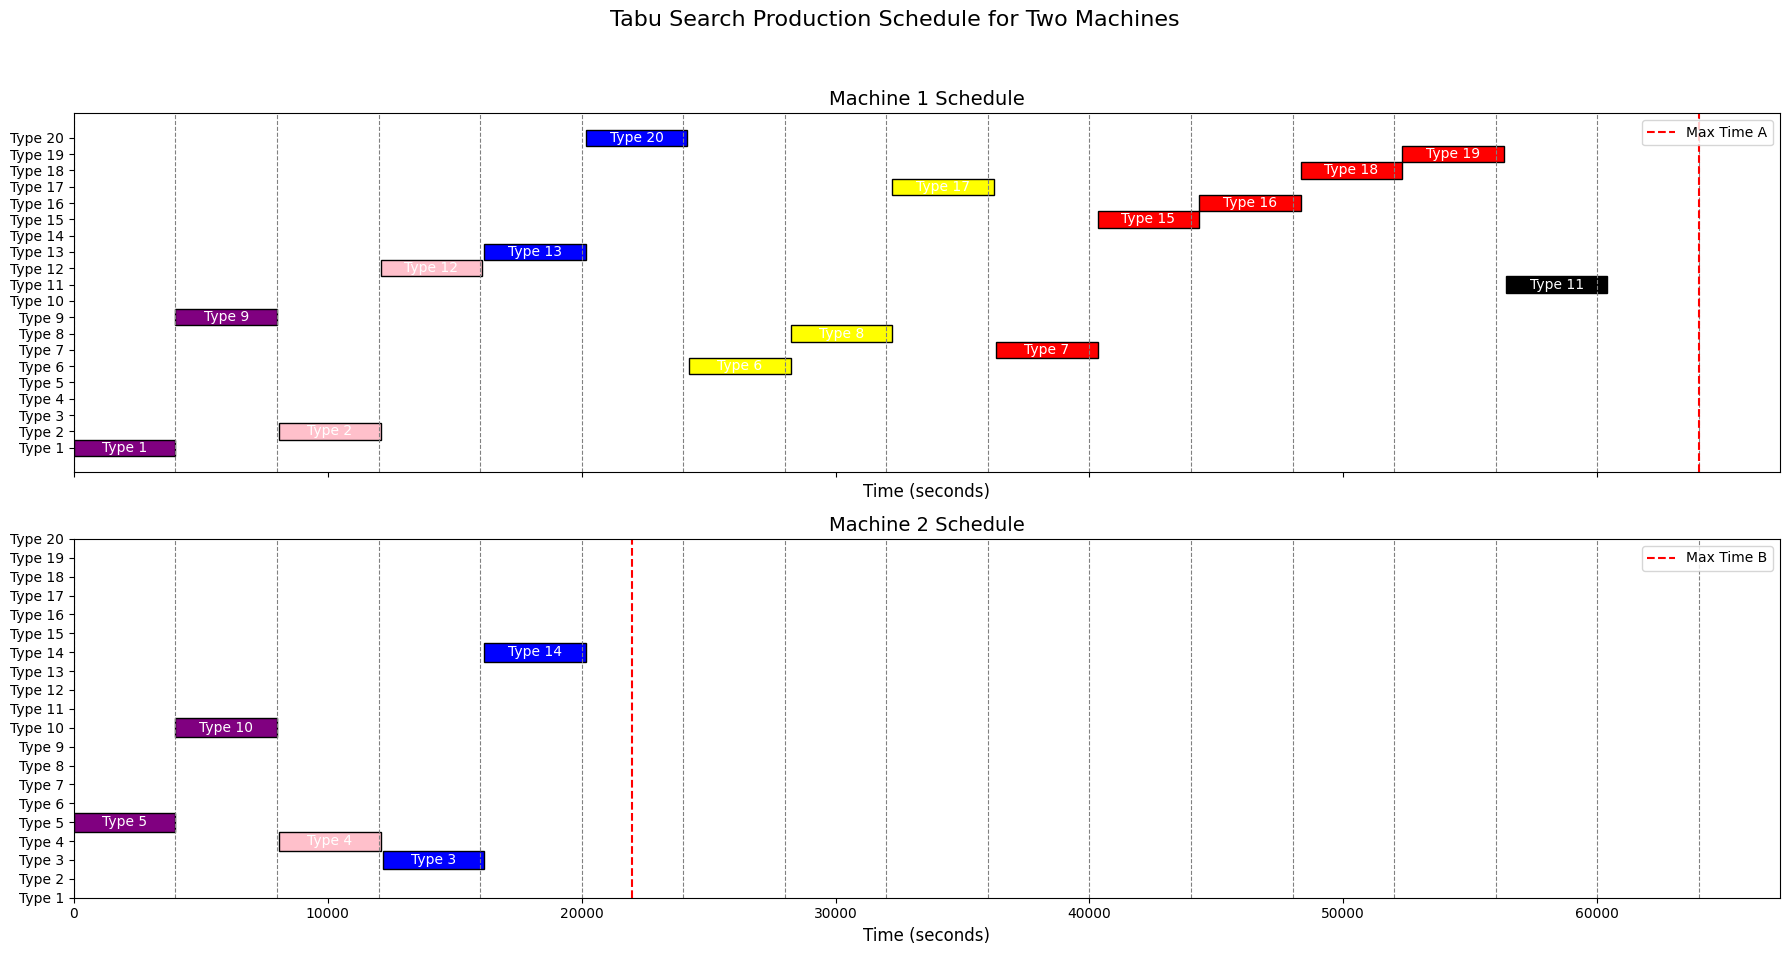

In [7]:
tabu.visualize()